#CMPE 257 FEVER Notebook

Team Data-Corps

*   Arun Talkad
*   Mayuri Lalwani
*   Yuxing Wang




## Prepare Environment

In [ ]:
! cd /content/ && rm -rf fake-news-detection-LIAR-pytorch && git clone https://github.com/YuxingW/fake-news-detection-LIAR-pytorch.git

Cloning into 'fake-news-detection-LIAR-pytorch'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 149 (delta 3), reused 3 (delta 1), pack-reused 140
Receiving objects: 100% (149/149), 46.34 MiB | 24.75 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [ ]:
import os 
os.chdir("/content/fake-news-detection-LIAR-pytorch")

## Network Architecture

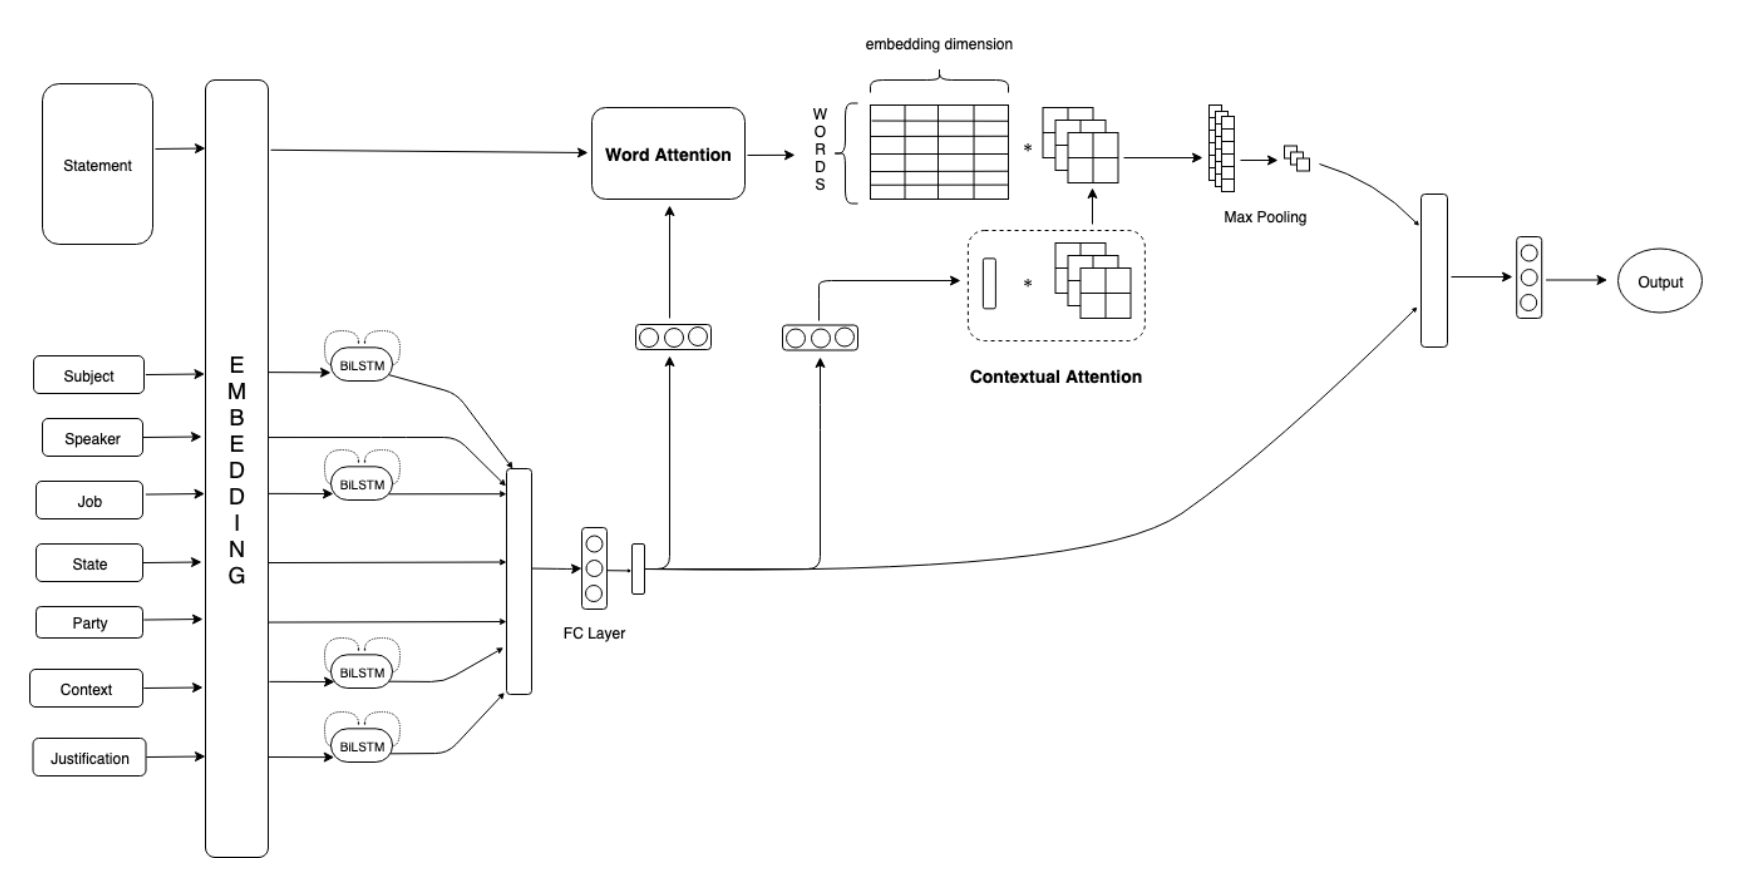

## Models

In [ ]:
#!/usr/bin/env python

import torch
import time
from data import train_data_prepare
from train import train
from test import test, test_data_prepare
from model import Net
from model_baseline import BaselineNet
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"


def loadModel(word2num, num_classes, hyper):

    statement_word2num = word2num[0]
    subject_word2num = word2num[1]
    speaker_word2num = word2num[2]
    speaker_pos_word2num = word2num[3]
    state_word2num = word2num[4]
    party_word2num = word2num[5]
    context_word2num = word2num[6]
    justification_word2num = word2num[7]
    all_word2num = word2num[8]
    
    # Construct model instance
    print('  Constructing network model...')
    model = BaselineNet(
                len(all_word2num),
                num_classes,
                embed_dim = hyper['embed_dim'],
                statement_kernel_num = hyper['statement_kernel_num'],
                statement_kernel_size = hyper['statement_kernel_size'],

                subject_hidden_dim = hyper['subject_hidden_dim'],
                subject_lstm_nlayers = hyper['subject_lstm_nlayers'],
                subject_lstm_bidirectional = hyper['subject_lstm_bidirectional'],

                speaker_pos_hidden_dim = hyper['speaker_pos_hidden_dim'],
                speaker_pos_lstm_nlayers = hyper['speaker_pos_lstm_nlayers'],
                speaker_pos_lstm_bidirectional = hyper['speaker_pos_lstm_bidirectional'],

                context_hidden_dim = hyper['context_hidden_dim'],
                context_lstm_nlayers = hyper['context_lstm_nlayers'],
                context_lstm_bidirectional = hyper['context_lstm_bidirectional'],

                justification_hidden_dim = hyper['justification_hidden_dim'],
                justification_lstm_nlayers = hyper['justification_lstm_nlayers'],
                justification_lstm_bidirectional = hyper['justification_lstm_bidirectional'],

                dropout_query = hyper['dropout_query'],
                dropout_features = hyper['dropout_features']
                )

    print("Hyperparams are:")
    for key in hyper:
        print(key, ": ", hyper[key])

    return model





In [ ]:
def driver(train_file, valid_file, test_file, output_file, dataset_name, mode, pathModel, hyper):
    '''
    Arguments
    ----------
    train_file: path to the training file
    valid_file: path to the validation file
    test_file: path to the testing file
    output_file: path to the output predictions to be saved
    dataset: 'LIAR' or 'LIAR-PLUS'
    mode: 'train' or 'test'
    pathModel: path to model saved weights
    '''

    timestampTime = time.strftime("%H%M%S")
    timestampDate = time.strftime("%d%m%Y")
    timestampLaunch = timestampDate + '-' + timestampTime
    parentPath = './models/'

    #---Hyperparams
    nnArchitecture = 'fake-net'
    lr = hyper['lr']
    epoch = hyper['epoch']
    use_cuda = False
    num_classes = hyper['num_classes']

    assert num_classes in [2, 6]

    print('dataset name: ', dataset_name)

    #-----------------TRAINING--------------
    if mode == 'train':
        #---prepare data
        train_samples, word2num = train_data_prepare(train_file, num_classes, dataset_name)
        valid_samples = test_data_prepare(valid_file, word2num, 'valid', num_classes, dataset_name)
        test_samples = test_data_prepare(test_file, word2num, 'test', num_classes, dataset_name)

        model = loadModel(word2num, num_classes, hyper)
        
        #---train and validate
        model, val_acc = train(train_samples, valid_samples, lr, epoch, model, num_classes, use_cuda, word2num, hyper, nnArchitecture, timestampLaunch)

        #---save model and embeddings
        pathModel = None

    #-----------------TESTING------------------
    if pathModel != None:
        pathModel = parentPath + pathModel

        modelCheckpoint = torch.load(pathModel, map_location=lambda storage, loc: storage)
        word2num = modelCheckpoint['word2num']
        hyper = modelCheckpoint['hyper']
        try:
            num_classes = hyper['num_classes']
        except:
            num_classes = 6
        test_samples = test_data_prepare(test_file, word2num, 'test', num_classes, dataset_name)

        model = loadModel(word2num, num_classes, hyper)
        
        device = torch.device('cuda') if use_cuda else torch.device('cpu')
        model.to(device)
        model.load_state_dict(modelCheckpoint['state_dict'])
        print("LOADED FROM PATHMODEL:", pathModel)

    else:
        print("PATHMODEL could not be loaded:", pathModel)

    test_acc = test(test_samples, output_file, model, num_classes, use_cuda)



## Train And Test

In [ ]:
def train_and_test(mode='train', dataset_name='LIAR', classes=2):

  if classes==2:
    pathModel = 'm-fake-net-num_classes-2-test_acc-0.633.pth.tar'
  else:
    pathModel = 'm-fake-net-num_classes-6-test_acc-0.249.pth.tar'

  if mode == 'test':
      assert pathModel != None, "pathModel cannot be None if testing"

  if dataset_name == 'LIAR':
      driver('train.tsv', 'valid.tsv', 'test.tsv', 'predictions.txt', dataset_name, mode, pathModel, hyper)
  else:
      driver('train2.tsv', 'val2.tsv', 'test2.tsv', 'predictions.txt', dataset_name, mode, pathModel, hyper)


In [ ]:
#---HYPERPARAMETERS

hyper = {
'num_classes': 6,
'epoch': 10,
'lr': 0.001,
'embed_dim': 100,
'statement_kernel_num': 64,
'statement_kernel_size': [3, 4, 5],

'subject_hidden_dim': 8,
'subject_lstm_nlayers': 2,
'subject_lstm_bidirectional': True,

'speaker_pos_hidden_dim': 8,
'speaker_pos_lstm_nlayers': 2,
'speaker_pos_lstm_bidirectional': True,

'context_hidden_dim': 16,
'context_lstm_nlayers': 2,
'context_lstm_bidirectional': True,

'justification_hidden_dim': 32,
'justification_lstm_nlayers': 2,
'justification_lstm_bidirectional': True,

'dropout_query': 0.5,
'dropout_features': 0.7
}


In [ ]:
# Traing takes 24h beyond, we skip it
#train_and_test()

In [ ]:
train_and_test(mode='test', dataset_name='LIAR', classes=6)

dataset name:  LIAR
fault: 0
  Constructing network model...
Hyperparams are:
epoch :  10
lr :  0.001
embed_dim :  100
statement_kernel_num :  64
statement_kernel_size :  [3, 4, 5]
subject_hidden_dim :  8
subject_lstm_nlayers :  2
subject_lstm_bidirectional :  True
speaker_pos_hidden_dim :  8
speaker_pos_lstm_nlayers :  2
speaker_pos_lstm_bidirectional :  True
context_hidden_dim :  16
context_lstm_nlayers :  2
context_lstm_bidirectional :  True
justification_hidden_dim :  32
justification_lstm_nlayers :  2
justification_lstm_bidirectional :  True
dropout_query :  0.5
dropout_features :  0.7
LOADED FROM PATHMODEL: ./models/m-fake-net-num_classes-6-test_acc-0.249.pth.tar
  Test Accuracy: 0.253


In [ ]:
train_and_test(mode='test', dataset_name='LIAR', classes=2)

dataset name:  LIAR
fault: 0
  Constructing network model...
Hyperparams are:
num_classes :  2
epoch :  10
lr :  0.001
embed_dim :  100
statement_kernel_num :  64
statement_kernel_size :  [3, 4, 5]
subject_hidden_dim :  8
subject_lstm_nlayers :  2
subject_lstm_bidirectional :  True
speaker_pos_hidden_dim :  8
speaker_pos_lstm_nlayers :  2
speaker_pos_lstm_bidirectional :  True
context_hidden_dim :  16
context_lstm_nlayers :  2
context_lstm_bidirectional :  True
justification_hidden_dim :  32
justification_lstm_nlayers :  2
justification_lstm_bidirectional :  True
dropout_query :  0.5
dropout_features :  0.7
LOADED FROM PATHMODEL: ./models/m-fake-net-num_classes-2-test_acc-0.633.pth.tar
  Test Accuracy: 0.622


In [ ]:
train_and_test(mode='test', dataset_name='LIAR-PLUS', classes=6)

dataset name:  LIAR-PLUS
fault: 0
  Constructing network model...
Hyperparams are:
epoch :  10
lr :  0.001
embed_dim :  100
statement_kernel_num :  64
statement_kernel_size :  [3, 4, 5]
subject_hidden_dim :  8
subject_lstm_nlayers :  2
subject_lstm_bidirectional :  True
speaker_pos_hidden_dim :  8
speaker_pos_lstm_nlayers :  2
speaker_pos_lstm_bidirectional :  True
context_hidden_dim :  16
context_lstm_nlayers :  2
context_lstm_bidirectional :  True
justification_hidden_dim :  32
justification_lstm_nlayers :  2
justification_lstm_bidirectional :  True
dropout_query :  0.5
dropout_features :  0.7
LOADED FROM PATHMODEL: ./models/m-fake-net-num_classes-6-test_acc-0.249.pth.tar
  Test Accuracy: 0.249


In [ ]:
train_and_test(mode='test', dataset_name='LIAR-PLUS', classes=2)

dataset name:  LIAR-PLUS
fault: 0
  Constructing network model...
Hyperparams are:
num_classes :  2
epoch :  10
lr :  0.001
embed_dim :  100
statement_kernel_num :  64
statement_kernel_size :  [3, 4, 5]
subject_hidden_dim :  8
subject_lstm_nlayers :  2
subject_lstm_bidirectional :  True
speaker_pos_hidden_dim :  8
speaker_pos_lstm_nlayers :  2
speaker_pos_lstm_bidirectional :  True
context_hidden_dim :  16
context_lstm_nlayers :  2
context_lstm_bidirectional :  True
justification_hidden_dim :  32
justification_lstm_nlayers :  2
justification_lstm_bidirectional :  True
dropout_query :  0.5
dropout_features :  0.7
LOADED FROM PATHMODEL: ./models/m-fake-net-num_classes-2-test_acc-0.633.pth.tar
  Test Accuracy: 0.633


## Results
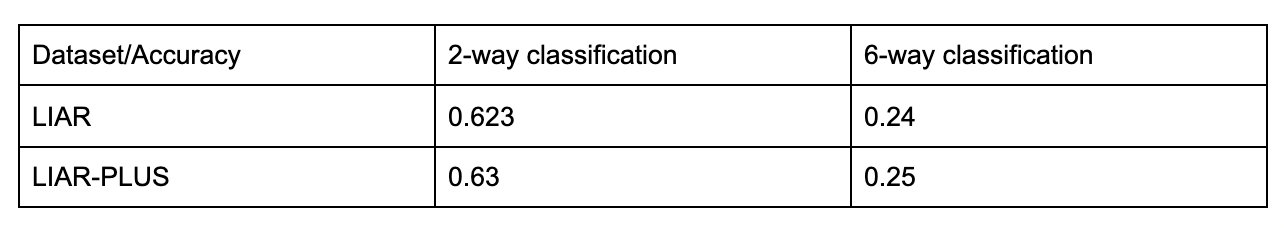